<a href="https://colab.research.google.com/github/Flaviofrc97/DASCIENSE-MACHINE-LEARNING/blob/main/predicit_fresh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import numpy as np
tf.__version__

'2.5.0'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = "/content/drive/MyDrive/Datasests/imagefresh/fresh.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
zip_object.close()

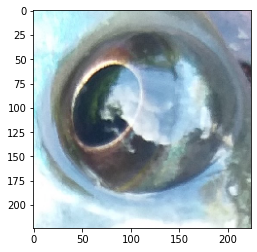

In [4]:
image = tf.keras.preprocessing.image.load_img(r'/content/train/fresh/20200517_084015.jpg', target_size=(224,224))
plt.imshow(image);

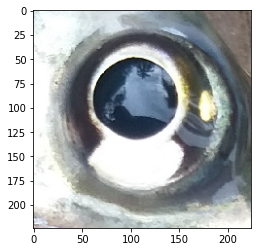

In [5]:
image = tf.keras.preprocessing.image.load_img(r'/content/train/no-fresh/20200517_145200.jpg', target_size=(224, 224))
plt.imshow(image);

In [6]:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
                                   rotation_range = 50,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   vertical_flip = True)

In [7]:
train_generator = train_datagen.flow_from_directory('/content/train',
                                                    target_size = (224, 224),
                                                    batch_size=12,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

Found 12 images belonging to 2 classes.


In [8]:
train_generator.n

12

In [9]:
train_generator.batch_size

12

In [10]:
step_size_train = train_generator.n // train_generator.batch_size
step_size_train

1

In [11]:
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [12]:
test_generator = test_datagen.flow_from_directory('/content/test',
                                                  target_size=(224,244),
                                                  batch_size=5,
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 28 images belonging to 2 classes.


In [13]:
step_size_test = test_generator.n // test_generator.batch_size

# **Transfer learning**

In [14]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 2s 0us/step


In [15]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [16]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
preds = tf.keras.layers.Dense(2, activation='softmax')(x)

In [17]:
model = tf.keras.Model(inputs = base_model.input, outputs = preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [18]:
for i, layer in enumerate(model.layers):
  print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [19]:
for layer in model.layers[:175]:
  layer.trainable = False  

In [20]:
for layer in model.layers[175:]:
  layer.trainable = True  

In [21]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
history = model.fit_generator(generator=train_generator,
                              epochs=10,
                              steps_per_epoch=step_size_train,
                              validation_data = test_generator,
                              validation_steps=step_size_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1/1 [==============================] - 41s 41s/step - loss: 0.6230 - accuracy: 0.5833 - val_loss: 2.3466 - val_accuracy: 0.4400
Epoch 2/10
1/1 [==============================] - 0s 416ms/step - loss: 2.8191 - accuracy: 0.5000 - val_loss: 5.9894 - val_accuracy: 0.5600
Epoch 3/10
1/1 [==============================] - 0s 410ms/step - loss: 7.3887 - accuracy: 0.5000 - val_loss: 2.8108 - val_accuracy: 0.5600
Epoch 4/10
1/1 [==============================] - 0s 413ms/step - loss: 3.2748 - accuracy: 0.5000 - val_loss: 0.2605 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 408ms/step - loss: 0.4103 - accuracy: 0.7500 - val_loss: 0.8689 - val_accuracy: 0.4400
Epoch 6/10
1/1 [==============================] - 0s 416ms/step - loss: 1.1885 - accuracy: 0.5000 - val_loss: 0.1513 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 418ms/step - loss: 0.1682 - accuracy: 1.0000 - val_loss: 0.4263 - val_accuracy: 0.7600
Epoch 8/10
1/1 [=====

# analysis

In [23]:
np.mean(history.history['val_accuracy'])

0.7680000007152558

In [24]:
np.std(history.history['val_accuracy'])

0.2324134261118632

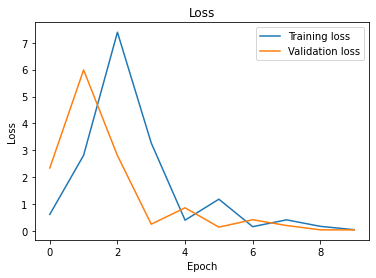

In [25]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend();

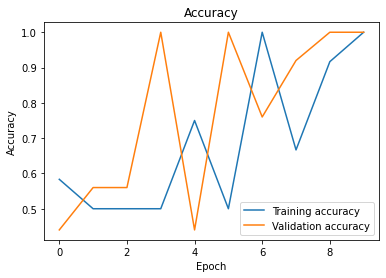

In [26]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend();

# PREDICTION 

In [27]:
filenames = test_generator.filenames
filenames

['fresh/20200517_084054.jpg',
 'fresh/20200517_084316.jpg',
 'fresh/20200517_084329.jpg',
 'fresh/20200517_084357.jpg',
 'fresh/20200517_084411.jpg',
 'fresh/20200517_084451.jpg',
 'fresh/20200517_084532.jpg',
 'fresh/20200517_084637.jpg',
 'fresh/20200517_084646.jpg',
 'fresh/20200517_084906.jpg',
 'fresh/20200517_084923.jpg',
 'fresh/20200517_085236.jpg',
 'fresh/20200517_085331.jpg',
 'fresh/20200517_085346.jpg',
 'no-fresh/20200517_145253.jpg',
 'no-fresh/20200517_145351.jpg',
 'no-fresh/20200517_145502.jpg',
 'no-fresh/20200517_145520.jpg',
 'no-fresh/20200517_145554.jpg',
 'no-fresh/20200517_145606.jpg',
 'no-fresh/20200517_145636.jpg',
 'no-fresh/20200517_145715.jpg',
 'no-fresh/20200517_145732.jpg',
 'no-fresh/20200517_145805.jpg',
 'no-fresh/20200517_145826.jpg',
 'no-fresh/20200517_145834.jpg',
 'no-fresh/20200517_145909.jpg',
 'no-fresh/20200517_145932.jpg']

In [28]:
len(filenames)

28

In [29]:
predictions = model.predict_generator(test_generator, steps = len(filenames))
predictions

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


array([[0.9916236 , 0.00837645],
       [0.97372794, 0.02627204],
       [0.9938338 , 0.00616623],
       [0.9891879 , 0.01081217],
       [0.9956807 , 0.0043193 ],
       [0.9639581 , 0.03604198],
       [0.9091625 , 0.09083754],
       [0.9142715 , 0.08572856],
       [0.7251507 , 0.2748493 ],
       [0.8784681 , 0.12153193],
       [0.87867856, 0.12132148],
       [0.9635469 , 0.03645315],
       [0.9191057 , 0.08089428],
       [0.97482884, 0.02517109],
       [0.08384666, 0.9161534 ],
       [0.01684179, 0.98315823],
       [0.00161606, 0.998384  ],
       [0.02997515, 0.9700248 ],
       [0.00414291, 0.99585706],
       [0.00292426, 0.9970758 ],
       [0.00362236, 0.99637765],
       [0.01424743, 0.9857525 ],
       [0.00333565, 0.99666435],
       [0.01777431, 0.98222566],
       [0.00516977, 0.9948302 ],
       [0.01392768, 0.9860723 ],
       [0.00500772, 0.9949923 ],
       [0.00350614, 0.9964939 ]], dtype=float32)

In [30]:
predictions2 = []
for i in range(len(predictions)):
  #print(predictions[i])
  predictions2.append(np.argmax(predictions[i]))

In [31]:
test_generator.class_indices

{'fresh': 0, 'no-fresh': 1}

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy_score(predictions2, test_generator.classes)

1.0

In [33]:
print(classification_report(predictions2,test_generator.classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        14

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28



In [34]:
cm = confusion_matrix(predictions2, test_generator.classes)
cm

array([[14,  0],
       [ 0, 14]])

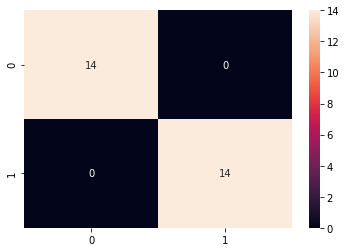

In [35]:
sns.heatmap(cm, annot=True);

#**TEST WITH IMAGE**

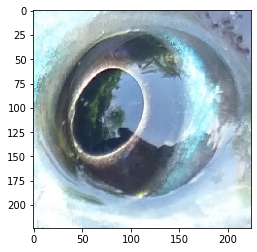

In [36]:
image = tf.keras.preprocessing.image.load_img(r'/content/test/fresh/20200517_084532.jpg', target_size=(224,224))
plt.imshow(image);

In [37]:
image = tf.keras.preprocessing.image.img_to_array(image)
np.shape(image)

(224, 224, 3)

In [38]:
np.max(image), np.min(image)

(255.0, 0.0)

In [39]:
image = np.expand_dims(image, axis = 0)
np.shape(image)

(1, 224, 224, 3)

In [40]:
image = tf.keras.applications.resnet50.preprocess_input(image)

In [41]:
np.max(image), np.min(image)

(151.061, -120.68)

In [42]:
predictions = model.predict(image)
print(predictions)

[[0.7988974 0.2011026]]


In [43]:
predictions[0]

array([0.7988974, 0.2011026], dtype=float32)

In [44]:
np.argmax(predictions[0])

0

In [45]:
list(train_generator.class_indices)

['fresh', 'no-fresh']

In [46]:
prediction = list(train_generator.class_indices)[np.argmax(predictions[0])]
print('the prediction is {}'.format(prediction))

the prediction is fresh
